In [1]:
import pandas as pd
import datetime 
import numpy as np
import scipy.stats as stats
from scipy.stats import norm, mannwhitneyu
%matplotlib inline
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use('ggplot')

## Задание 1
Retention – один из самых важных показателей в компании. Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [2]:
#Подготовим данные к работе
reg_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashchenko/shared/problem1-reg_data.csv', sep=(';'))
auth_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashchenko/shared/problem1-auth_data.csv', sep=(';'))

reg_df- данные о дате регистрации, а auth_df - данные о дате входа

In [3]:
reg_df.head(5)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
reg_df.dtypes

reg_ts    int64
uid       int64
dtype: object

In [5]:
reg_df.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [6]:
auth_df.head(5)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [7]:
auth_df.dtypes

auth_ts    int64
uid        int64
dtype: object

In [8]:
auth_df.isna().sum()

auth_ts    0
uid        0
dtype: int64

### Для того, чтобы произвести расчет retention по каждому дню определенного месяца необходимо сделать следующие:

1) сменить формат даты из UNIX в привычный дня нас дейт тайм;  
2) определить временной промежуток для анализа;  
3) замерджить таблицы;  
4) вычислить временную разницу между регистрацией и входом;   
5) сфоримовать когорты;   
6) визуализировать

In [9]:
def retention(reg_data, auth_data):
    
    #1
    reg_data['reg_date'] = pd.to_datetime(reg_df['reg_ts'], unit='s').dt.date
    auth_data['auth_date'] = pd.to_datetime(auth_df['auth_ts'], unit='s').dt.date
    
    #2
    reg_data = reg_data[(reg_data['reg_date'] >= datetime.date(2019,8,1))]
    auth_data = auth_data[(auth_data['auth_date'] <= datetime.date(2019,8,31))]

    #3
    full_data = pd.merge(reg_data, auth_data, on='uid')
    
    #4
    full_data['diff_date'] = (full_data['auth_date'] - full_data['reg_date']).dt.days + 1
    
    #5
    cohorts_df = full_data.groupby(['reg_date', 'diff_date'])['uid'].nunique().reset_index() 
    cohorts = cohorts_df.pivot(index='reg_date', columns='diff_date', values='uid')
    base = cohorts[1] 
    retention = cohorts.divide(base, axis=0).round(3)
    
    #6
    plt.figure(figsize=(20,15))
    plt.title('Retention for August 2019')
    ax = sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.15, cmap='coolwarm')
    ax.set_yticklabels(retention.index)
    fig=ax.get_figure()
    plt.show()
    
    return{"retention_data": retention}  

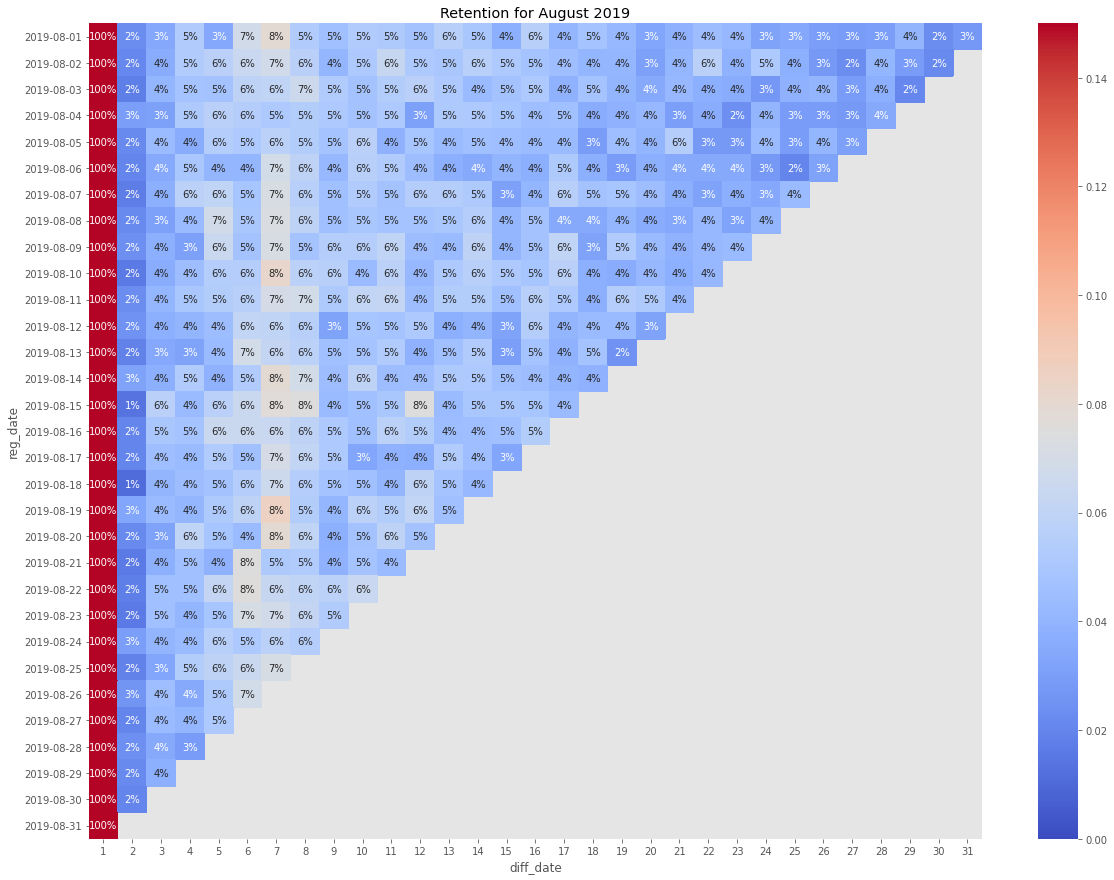

In [10]:
retention_data = retention(reg_df, auth_df) 

Мы видим, что пользователи мало возвращаются на платформу (за анализируемый период), что может быть следствием нескольких факторо, например, отсутвствие интереса к игре.
        

## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [11]:
df= pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashchenko/shared/problem2.csv', sep=(';'))
df.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [13]:
df.shape

(404770, 3)

In [14]:
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [15]:
 df.groupby('testgroup').describe()

user_id                                                         \
              count           mean            std  min       25%       50%   
testgroup                                                                    
a          202103.0  202555.909843  116802.329266  2.0  101502.5  202988.0   
b          202667.0  202215.564389  116891.926690  1.0  100855.5  201821.0   

                                revenue                                        \
                75%       max     count       mean         std  min  25%  50%   
testgroup                                                                       
a          303559.0  404769.0  202103.0  25.413720  920.768137  0.0  0.0  0.0   
b          303602.5  404770.0  202667.0  26.751287  287.324162  0.0  0.0  0.0   

                         
           75%      max  
testgroup                
a          0.0  37433.0  
b          0.0   4000.0

In [16]:
df.query('revenue > 0').groupby('testgroup').agg({'user_id':'nunique'})

,user_id
testgroup,
a,1928
b,1805


Посмотрим на то, как распределяются значения для групп  
где А - контрольная, а   
         В - тестовая группы  

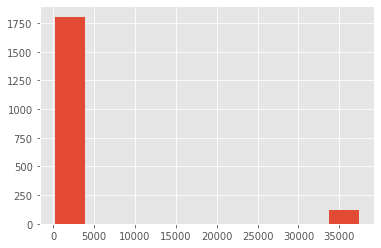

In [17]:
rev_df = df.query('revenue > 0')
rev_df.query("testgroup == 'a' and revenue > 0").revenue.hist()

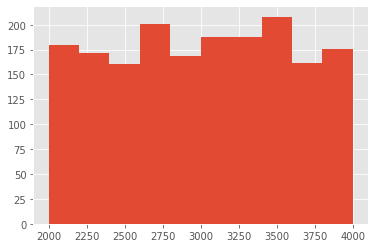

In [18]:
rev_df.query("testgroup == 'b' and revenue > 0").revenue.hist()

### Рассмотрим метрики ARPU, ARPPU, CR


In [19]:
conversion = (df.query('revenue > 0').groupby('testgroup').agg({'user_id':'nunique'})
      /df.groupby('testgroup').agg({'user_id':'nunique'})*100).round(2)
conversion

,user_id
testgroup,
a,0.95
b,0.89


In [20]:
arpu = df \
    .groupby('testgroup', as_index = False) \
    .agg({'revenue' : 'mean'}) \
    .rename(columns = {'revenue' : 'ARPU'})

In [21]:
arppu = df \
    .query('revenue > 0') \
    .groupby('testgroup', as_index = False) \
    .agg({'revenue' : 'mean'}) \
    .rename(columns = {'revenue' : 'ARPPU'})

In [22]:
aa= arpu.merge(arppu, how='outer')
aa.round(2)

,testgroup,ARPU,ARPPU
0,a,25.41,2664.00
1,b,26.75,3003.66


Text(0.5, 1.0, 'Разница ARPU 5%')

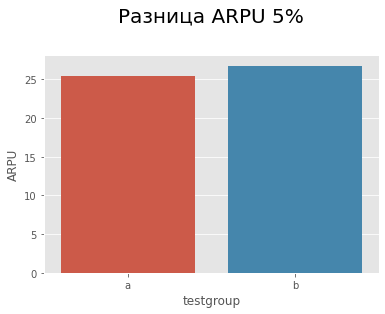

In [23]:
arpu_diff = sns.barplot(x='testgroup', y='ARPU', data=arpu)
arpu_diff.set_title(f'''Разница ARPU {round((arpu['ARPU'][1]-arpu['ARPU'][0]) / arpu['ARPU'][0] * 100)}%''', fontsize = 20, pad = 34)

Text(0.5, 1.0, 'Разница ARPPU 13%')

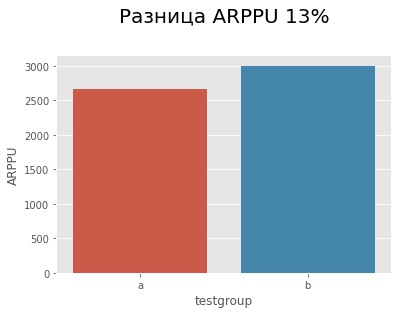

In [24]:
arppu_diff = sns.barplot(x='testgroup', y='ARPPU', data=arppu)
arppu_diff.set_title(f'''Разница ARPPU {round((arppu['ARPPU'][1]-arppu['ARPPU'][0]) / arppu['ARPPU'][0] * 100)}%''', fontsize = 20, pad = 34)

### проведем bootstrap

In [25]:
x = df.query("testgroup == 'a' & revenue > 0")['revenue']
y = df.query("testgroup == 'b' & revenue > 0")['revenue']

In [26]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

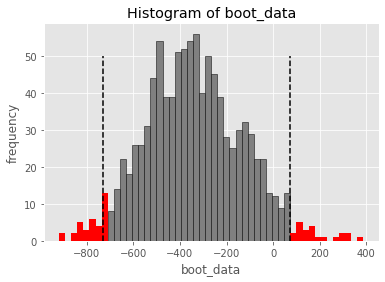

In [27]:
booted_data = get_bootstrap(x, y)

In [28]:
 booted_data['p_value']

0.10085997170809864

p_value > 0.05, стат значимых различий нет

In [29]:
#ARPU
df.groupby('testgroup', as_index = False).agg({'revenue' : 'mean'})

,testgroup,revenue
0,a,25.413720
1,b,26.751287


In [30]:
x = df.query("testgroup == 'a'")['revenue']
y = df.query("testgroup == 'b'")['revenue']

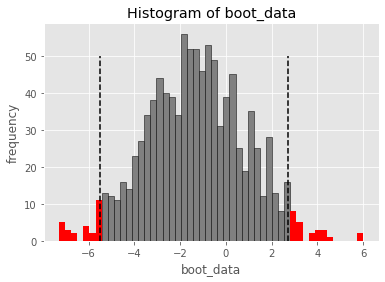

In [31]:
booted_data = get_bootstrap(x, y)

In [32]:
booted_data['p_value']

0.5424273995612638

p_value > 0.05, стат значимых различий нет

### Проверим гипотезу с помошью критерия Манна-Уитни

 H0: Различия не являются статистически достоверными и носят случайный характер   
 H1: Различия являются статистически достоверными

In [33]:
stat, p = mannwhitneyu(control.revenue, test.revenue)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

NameError: name 'control' is not defined

### Заключение по заданию:   
Оказывается, что ARPU в тестовой группе выше на 5%, а ARPPU - выше на 13% (скорее всего случайность).  Конверсия же на 7% больше в контрольной группе, чем в тестовой.

Результаты A/B-тестирования показали, что значимых статистических различий в контрольной и тестовой группах нет, тк p_value > 0.05

тест Манн-Уитни показал разницу распределений

Имеются различия в размере ср. чека: в контрольнойогромный размах до 35000, в тестовой группе ср. чек стабилен и находится в пределах 2000-4000.

Как итог, не стоит выкатывать обновление

## Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

## Для оценки рнзультатов, я бы рекомендовала использовать такие метрики как:
### 1) метрики мобильных приложений:
      Отстеживая данные метрики, мы сможем ответить на вопрос "А интересны ли вообще ивент нашим игрокам?" В последующем, рл этим же метрикам можно сравнивать эффективность прошедших ивентов и реранить их     
      
      1.1. DAU (Daily Active Users) —  количество уникальных пользователей за сутки    
      1.2. WAU (Weekly Active Users) — это количество пользователей за неделю    
      1.3. MAU (Monthly Active Users) — это количество уникальных пользователей за месяц (если вдруг мы захотим продлить ивент)
      1.4. Stickness  (коэффициент «липучести») — показатель лояльности аудитории к приложению. Показывает, как часто клиенты возвращаются в приложение в течение недели или месяца.  DAU/WAU (MAU) * 100%
      В интерпритации все просто, высокая липучесть = мы делаем все правильно
      1.5. ASD (Average Session Duration) — это среднее время сессий за период времени.ASD = Суммарная продолжительность сессий за период / общее количество сессий за тот же период.
      
      
### 2) метрики для оценки финансовой составляющей:
      2.1. ARPU (Average Revenue Per User) — средняя прибыль с одного клиента за конкретный период          
      2.2. ARPPU (Average Revenue Per Paying User) — средняя прибыль с одного платящего клиента за конкретный период. 
      2.3. ATV (Average Transaction Value) — средняя стоимость покупок за период, средний чек.ATV = Общая сумма покупок / количество покупок. Можно разделить пользователей на сегменты с «маленьким», «средним» и «большим» средним чеком. Потом сравнить эти сегменты по активности. И уже на основе этих данных строить маркетинговую стратегию.
      
      
### 3) Иные метрики:
      3.1. RR (Retention rate) - Процент клиентов, которые возвращаются в приложение.Retention рассчитывается как отношение вернувшихся в приложение пользователей к числу установивших его в определённую дату.
      3.2. ChR (Churn rate) - «Выгорание» или отток пользователей. Это как Retention Rate, только наоборот: 100% − Retention = Churn Rate. Churn Rate позволяет взглянуть на проблему под другим углом: не искать новые методы удержания пользователей, а понять, почему они уходят. Например, отток пользователей может сигнализировать о том, что в приложении что-то сломалось.
      3.3. CSAT (Customer Satisfaction Score) или индекс удовлетворенности клиентов. CSAT — это показатель, который позволяет понять, насколько клиенту понравилось взаимодействовать с компанией. Его измеряют, задавая прямой вопрос клиенту. 

### При предложенном усложнении ивентов нужно добавить такие метрики как
 1.1. Показатель LTV (Lifetime)  — это метрика, которая показывает, в течение какого времени человек остается активным пользователем продукта (цикл от первого до последнего запуска сервиса).
 1.2. уделять больше внимания метрикам   CSAT и Churn rate